# TASK 7 - THE SPARKS FOUNDATION - STOCK MARKET ANALYSIS

# Author - JAIDEEPNATH ANAND S

In [2]:
#import libraries 
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import altair as alt  #Altair is a declarative statistical visualization library for Python

import statsmodels.api as sm 

from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.multioutput import RegressorChain
from sklearn.ensemble import RandomForestRegressor

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:

import yfinance as yf
bse_data = yf.download('^BSESN', start='2015-01-01', end='2020-11-03')
unseenbse_data = yf.download('^BSESN', start='2020-11-03', end='2020-11-04')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [5]:

pip install yfinance --upgrade --no-cache-dir

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install altair vega_datasets

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: jsonschema in d:\anaconda\lib\site-packages (from altair) (3.2.0)



In [7]:
bse_data.isnull().sum()


Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [8]:
unseenbse_data.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [9]:

bse_data.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [10]:

unseenbse_data.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [11]:
bse_data.rename(columns={'Open': 'open', 'High': 'high', 'Low': 'low', 'Close': 'close', 'Adj Close': 'adjclose', 'Volume': 'volume'}, inplace = True)
unseenbse_data.rename(columns={'Open': 'open', 'High': 'high', 'Low': 'low', 'Close': 'close', 'Adj Close': 'adjclose', 'Volume': 'volume'}, inplace = True)

# ----------

In [12]:

bse_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1434 entries, 2015-01-02 to 2020-11-02
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   open      1434 non-null   float64
 1   high      1434 non-null   float64
 2   low       1434 non-null   float64
 3   close     1434 non-null   float64
 4   adjclose  1434 non-null   float64
 5   volume    1434 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 78.4 KB


In [13]:
unseenbse_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1 entries, 2020-11-03 to 2020-11-03
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   open      1 non-null      float64
 1   high      1 non-null      float64
 2   low       1 non-null      float64
 3   close     1 non-null      float64
 4   adjclose  1 non-null      float64
 5   volume    1 non-null      int64  
dtypes: float64(5), int64(1)
memory usage: 56.0 bytes


In [14]:
bse_data.head()

,open,high,low,close,adjclose,volume
Date,,,,,,
2015-01-02,27521.279297,27937.470703,27519.259766,27887.900391,27887.900391,7400
2015-01-05,27978.429688,28064.490234,27786.849609,27842.320312,27842.320312,9200
2015-01-06,27694.230469,27698.929688,26937.060547,26987.460938,26987.460938,14100
2015-01-07,26983.429688,27051.599609,26776.119141,26908.820312,26908.820312,12200
2015-01-08,27178.769531,27316.410156,27101.939453,27274.710938,27274.710938,8200


In [15]:

bse_data.tail()
bse_data.reset_index(inplace=True)
bse_data.rename(columns={'Date': 'date'}, inplace = True)

bse_data.head()

,date,open,high,low,close,adjclose,volume
0,2015-01-02,27521.279297,27937.470703,27519.259766,27887.900391,27887.900391,7400
1,2015-01-05,27978.429688,28064.490234,27786.849609,27842.320312,27842.320312,9200
2,2015-01-06,27694.230469,27698.929688,26937.060547,26987.460938,26987.460938,14100
3,2015-01-07,26983.429688,27051.599609,26776.119141,26908.820312,26908.820312,12200
4,2015-01-08,27178.769531,27316.410156,27101.939453,27274.710938,27274.710938,8200


In [16]:
unseenbse_data.reset_index(inplace=True)
unseenbse_data.rename(columns={'Date': 'date'}, inplace = True)

unseenbse_data.head()

,date,open,high,low,close,adjclose,volume
0,2020-11-03,39990.75,40354.730469,39952.789062,40261.128906,40261.128906,21400


In [17]:

bse_data['date'] = pd.to_datetime(bse_data['date'], format = '%Y%m%d')
unseenbse_data['date'] = pd.to_datetime(unseenbse_data['date'], format = '%Y%m%d')

In [18]:
#before moving forward let us calculate first the actual price
unseenbsedata_price = round((unseenbse_data['high'] + unseenbse_data['low'] + unseenbse_data['close'])/ 3, 2)
unseenbsedata_price  #actual price

0    40189.55
dtype: float64

# --------

In [19]:

def stock_weekmovingavg(wks, df):
    dateclose_data = pd.DataFrame({'date': df['date'], 'close':df['close']})
    dateclose_data.set_index('date', inplace=True)
    num = wks * 5                                 #calculating the number of days in the week. 5 days because BSE is open for 5 days / week
    dateclose_data['movingavg'] = dateclose_data['close'].rolling(window=num).mean().shift()
    return dateclose_data.dropna()

In [20]:
stock_weekmovingavg(4, bse_data).head()

,close,movingavg
date,,
2015-02-02,29122.269531,28256.509570
2015-02-03,29000.140625,28318.228027
2015-02-04,28883.109375,28376.119043
2015-02-05,28850.970703,28470.901465
2015-02-06,28717.910156,28568.008984


<AxesSubplot:xlabel='date'>

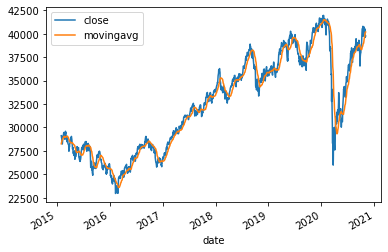

In [21]:
stock_weekmovingavg(4, bse_data).plot()

In [22]:

altdata_fourweek = stock_weekmovingavg(4, bse_data)
altdata_fourweek.reset_index(inplace=True)
altdata_fourweek.rename(columns={list(altdata_fourweek)[0]:'date'}, inplace=True)

In [23]:

alt.Chart(altdata_fourweek).mark_point().encode(
    x='date',
    y='movingavg'
)

alt.Chart(...)

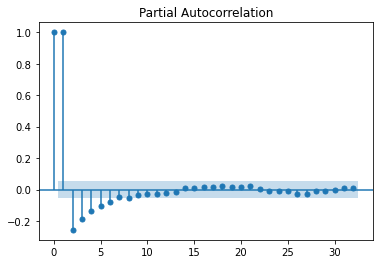

In [24]:
plotfourweek = altdata_fourweek.filter(['date', 'movingavg'], axis=1) #df.copy()
plotfourweek.index = pd.Index(sm.tsa.datetools.dates_from_range('2015', length=len(altdata_fourweek['date']))) 
del plotfourweek['date']
sm.graphics.tsa.plot_pacf(plotfourweek.values.squeeze())
plt.show()

<AxesSubplot:xlabel='date'>

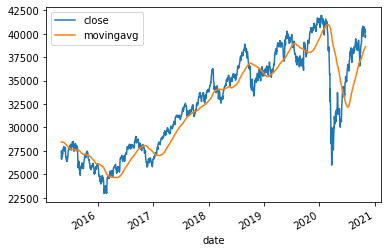

In [25]:

stock_weekmovingavg(16, bse_data).head()
stock_weekmovingavg(16, bse_data).plot()

In [26]:
altdata_sixteenweek = stock_weekmovingavg(16, bse_data)
altdata_sixteenweek.reset_index(inplace=True)
altdata_sixteenweek.rename(columns={list(altdata_sixteenweek)[0]:'date'}, inplace=True)

In [27]:

alt.Chart(altdata_sixteenweek).mark_point().encode(
    x='date',
    y='movingavg'
)

alt.Chart(...)

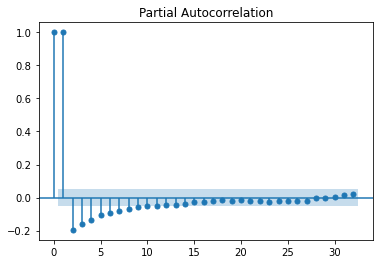

In [28]:

plotsixteenweek = altdata_sixteenweek.filter(['date', 'movingavg'], axis=1) #df.copy()
plotsixteenweek.index = pd.Index(sm.tsa.datetools.dates_from_range('2015', length=len(altdata_sixteenweek['date']))) 
del plotsixteenweek['date']
sm.graphics.tsa.plot_pacf(plotsixteenweek.values.squeeze())
plt.show()

<AxesSubplot:xlabel='date'>

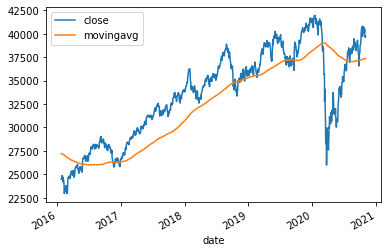

In [29]:
stock_weekmovingavg(52, bse_data).head()
stock_weekmovingavg(52, bse_data).plot()

In [30]:
altdata_fiftytwoweek = stock_weekmovingavg(52, bse_data)
altdata_fiftytwoweek.reset_index(inplace=True)
altdata_fiftytwoweek.rename(columns={list(altdata_fiftytwoweek)[0]:'date'}, inplace=True)
alt.Chart(altdata_fiftytwoweek).mark_point().encode(
    x='date',
    y='movingavg'
)

alt.Chart(...)

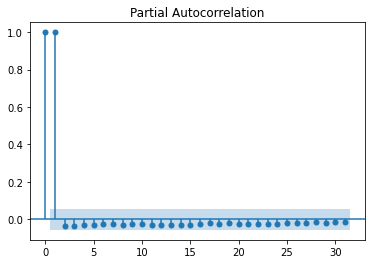

In [31]:
plotfiftytwoweek = altdata_fiftytwoweek.filter(['date', 'movingavg'], axis=1) #df.copy()
plotfiftytwoweek.index = pd.Index(sm.tsa.datetools.dates_from_range('2015', length=len(altdata_fiftytwoweek['date']))) 
del plotfiftytwoweek['date']
sm.graphics.tsa.plot_pacf(plotfiftytwoweek.values.squeeze())
plt.show()

# ----

In [32]:

def rollingwindows(days, df):
    data = df.filter(['date','open','high','low','close'], axis=1) #df.copy()
    data.set_index('date', inplace=True)
    rollingwindows_data = data.rolling(window=days).mean().shift()
    return rollingwindows_data.dropna()

<AxesSubplot:xlabel='date'>

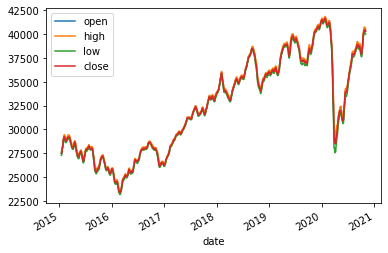

In [33]:

rollingwindows(10, bse_data).head()
rollingwindows(10, bse_data).plot()

In [34]:

altdata_tendays = rollingwindows(10, bse_data)
altdata_tendays.reset_index(inplace=True)
altdata_tendays.rename(columns={list(altdata_tendays)[0]:'date'}, inplace=True)

In [35]:

alt.Chart(altdata_tendays).mark_point().encode(
    x ='date',
    y = 'close'
)

alt.Chart(...)

<AxesSubplot:xlabel='date'>

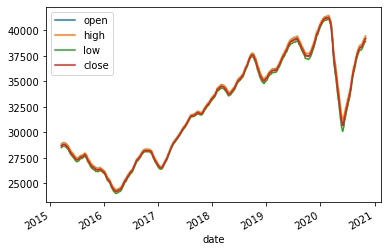

In [36]:
rollingwindows(50, bse_data).head()
rollingwindows(50, bse_data).plot()

In [37]:
altdata_fiftydays = rollingwindows(50, bse_data)
altdata_fiftydays.reset_index(inplace=True)
altdata_fiftydays.rename(columns={list(altdata_fiftydays)[0]:'date'}, inplace=True)

In [38]:
alt.Chart(altdata_fiftydays).mark_point().encode(
    x='date',
    y='close'
)

alt.Chart(...)

# ----

In [39]:

def boolean_shock(percent, df, col):
    data = df.filter(['date', col], axis=1) #df.copy()
    data.set_index('date', inplace=True)
    data['percentchg'] = (data[col].pct_change()) * 100  #percentage change compare to previous volume using pct_change() function
    data['shock'] = data['percentchg'].apply(lambda x: 1 if x >= percent else 0)
    data.drop(col, axis = 1, inplace = True)
    return data.dropna()

In [40]:
boolean_shock(10, bse_data, 'volume')

,percentchg,shock
date,,
2015-01-05,24.324324,1
2015-01-06,53.260870,1
2015-01-07,-13.475177,0
2015-01-08,-32.786885,0
2015-01-09,35.365854,1
...,...,...
2020-10-27,37.623762,1
2020-10-28,111.510791,1
2020-10-29,-33.673469,0


In [41]:
altdata_volpercentchg = boolean_shock(10, bse_data, 'volume')
altdata_volpercentchg.reset_index(inplace=True)
altdata_volpercentchg.rename(columns={list(altdata_volpercentchg)[0]:'date'}, inplace=True)

alt.Chart(altdata_volpercentchg).mark_point().encode(
    x='date',
    y='percentchg'
)

alt.Chart(...)

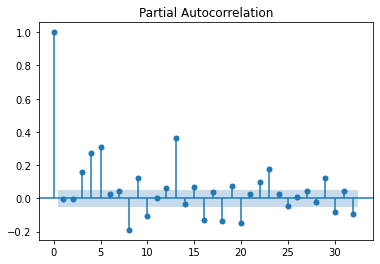

In [42]:
plotvolpercentchg = altdata_volpercentchg.filter(['date', 'percentchg'], axis=1) #df.copy()
plotvolpercentchg.index = pd.Index(sm.tsa.datetools.dates_from_range('2015', length=len(altdata_volpercentchg['date']))) 
del plotvolpercentchg['date']
sm.graphics.tsa.plot_pacf(plotvolpercentchg.values.squeeze())
plt.show()

In [43]:

boolean_shock(2, bse_data, 'close')

,percentchg,shock
date,,
2015-01-05,-0.163440,0
2015-01-06,-3.070360,0
2015-01-07,-0.291397,0
2015-01-08,1.359742,0
2015-01-09,0.673407,0
...,...,...
2020-10-27,0.938092,0
2020-10-28,-1.479787,0
2020-10-29,-0.432362,0


In [44]:

altdata_closepercentchg2 = boolean_shock(2, bse_data, 'close')
altdata_closepercentchg2.reset_index(inplace=True)
altdata_closepercentchg2.rename(columns={list(altdata_closepercentchg2)[0]:'date'}, inplace=True)

In [45]:

alt.Chart(altdata_closepercentchg2).mark_point().encode(
    x='date',
    y='percentchg'
)

alt.Chart(...)

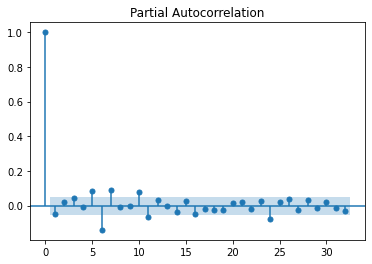

In [46]:

plotclosepercentchg2 = altdata_closepercentchg2.filter(['date', 'percentchg'], axis=1) #df.copy()
plotclosepercentchg2.index = pd.Index(sm.tsa.datetools.dates_from_range('2015', length=len(altdata_closepercentchg2['date']))) 
del plotclosepercentchg2['date']
sm.graphics.tsa.plot_pacf(plotclosepercentchg2.values.squeeze())
plt.show()

In [47]:
boolean_shock(10, bse_data, 'close')


,percentchg,shock
date,,
2015-01-05,-0.163440,0
2015-01-06,-3.070360,0
2015-01-07,-0.291397,0
2015-01-08,1.359742,0
2015-01-09,0.673407,0
...,...,...
2020-10-27,0.938092,0
2020-10-28,-1.479787,0
2020-10-29,-0.432362,0


In [48]:

altdata_closepercentchg10 = boolean_shock(10, bse_data, 'close')
altdata_closepercentchg10.reset_index(inplace=True)
altdata_closepercentchg10.rename(columns={list(altdata_closepercentchg10)[0]:'date'}, inplace=True)

In [49]:
alt.Chart(altdata_closepercentchg10).mark_point().encode(
    x='date',
    y='percentchg'
)

alt.Chart(...)

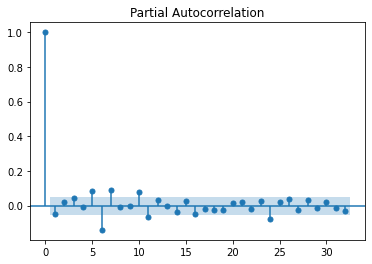

In [50]:
plotclosepercentchg10 = altdata_closepercentchg10.filter(['date', 'percentchg'], axis=1) #df.copy()
plotclosepercentchg10.index = pd.Index(sm.tsa.datetools.dates_from_range('2015', length=len(altdata_closepercentchg10['date']))) 
del plotclosepercentchg10['date']
sm.graphics.tsa.plot_pacf(plotclosepercentchg10.values.squeeze())
plt.show()

# -----

In [51]:
def priceboolean_shock(percent, df):
    df['date'] = pd.to_datetime(df['date'])
    data = df.filter(['date', 'high', 'low','close'], axis=1) #df.copy()
    data.set_index('date', inplace=True)
    data['priceavg'] = (data['high'] + data['low'] + data['close']) / 3
    data['shock'] = (data['priceavg'].pct_change()) * 100
    data['shock'] = data['shock'].apply(lambda x: 1 if x >= percent else 0)
    data.drop(['high', 'low', 'close'], axis = 1, inplace = True)
    return data

In [52]:

priceboolean_shock(10, bse_data)

,priceavg,shock
date,,
2015-01-02,27781.543620,0
2015-01-05,27897.886719,0
2015-01-06,27207.817057,0
2015-01-07,26912.179688,0
2015-01-08,27231.020182,0
...,...,...
2020-10-27,40352.031250,0
2020-10-28,40120.471354,0
2020-10-29,39761.643229,0


In [53]:
altdata_pricepercentchg = priceboolean_shock(10, bse_data)
altdata_pricepercentchg.reset_index(inplace=True)
altdata_pricepercentchg.rename(columns={list(altdata_pricepercentchg)[0]:'date'}, inplace=True)
alt.Chart(altdata_pricepercentchg).mark_point().encode(
    x='date',
    y='priceavg'
)

alt.Chart(...)

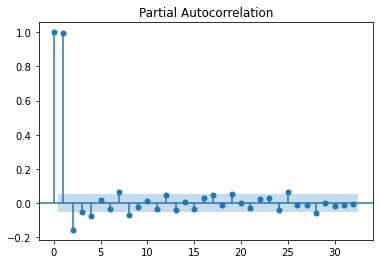

In [54]:
plotpricepercentchg = altdata_pricepercentchg.filter(['date', 'priceavg'], axis=1) #df.copy()
plotpricepercentchg.index = pd.Index(sm.tsa.datetools.dates_from_range('2015', length=len(altdata_pricepercentchg['date']))) 
del plotpricepercentchg['date']
sm.graphics.tsa.plot_pacf(plotpricepercentchg.values.squeeze())
plt.show()

# ----

In [55]:

def reverseboolean_shock(percent, df, col):
    data = df.filter(['date', col], axis=1) #df.copy()
    data.set_index('date', inplace=True)
    data = data.reindex(index=data.index[::-1])
    data['percentchg'] = (data[col].pct_change()) * 100
    data['shock'] = data['percentchg'].apply(lambda x: 1 if x > percent else 0)
    data.drop(col, axis = 1, inplace = True)
    data = data.reindex(index=data.index[::-1])
    return data.dropna()

In [56]:
reverseboolean_shock(2, bse_data, 'close')

,percentchg,shock
date,,
2015-01-02,0.163708,0
2015-01-05,3.167617,1
2015-01-06,0.292249,0
2015-01-07,-1.341501,0
2015-01-08,-0.668903,0
...,...,...
2020-10-26,-0.929373,0
2020-10-27,1.502013,0
2020-10-28,0.434239,0


In [57]:
altdata_closepercentchg = reverseboolean_shock(2, bse_data, 'close')
altdata_closepercentchg.reset_index(inplace=True)
altdata_closepercentchg.rename(columns={list(altdata_closepercentchg)[0]:'date'}, inplace=True)

In [58]:
alt.Chart(altdata_closepercentchg).mark_point().encode(
    x='date',
    y='percentchg'
)

alt.Chart(...)

In [59]:
reverseboolean_shock(5, bse_data, 'close')

,percentchg,shock
date,,
2015-01-02,0.163708,0
2015-01-05,3.167617,0
2015-01-06,0.292249,0
2015-01-07,-1.341501,0
2015-01-08,-0.668903,0
...,...,...
2020-10-26,-0.929373,0
2020-10-27,1.502013,0
2020-10-28,0.434239,0


In [60]:

altdata_closepercentchg5 = reverseboolean_shock(5, bse_data, 'close')
altdata_closepercentchg5.reset_index(inplace=True)
altdata_closepercentchg5.rename(columns={list(altdata_closepercentchg5)[0]:'date'}, inplace=True)

In [61]:

alt.Chart(altdata_closepercentchg5).mark_point().encode(
    x='date',
    y='percentchg'
)

alt.Chart(...)

In [62]:
def pricereverseboolean_shock(percent, df):
    data = df.filter(['date', 'high', 'low','close'], axis=1) #df.copy()
    data.set_index('date', inplace=True)
    data = data.reindex(index=data.index[::-1])
    data['reversepriceavg'] = (data['high'] + data['low'] + data['close']) / 3
    data['shock'] = (data['reversepriceavg'].pct_change()) * 100
    data['shock'] = data['shock'].apply(lambda x: 1 if x >= percent else 0)
    data.drop(['high', 'low', 'close'], axis = 1, inplace = True)
    data = data.reindex(index=data.index[::-1])
    return data.dropna()

In [63]:

pricereverseboolean_shock(2, bse_data)

,reversepriceavg,shock
date,,
2015-01-02,27781.543620,0
2015-01-05,27897.886719,1
2015-01-06,27207.817057,0
2015-01-07,26912.179688,0
2015-01-08,27231.020182,0
...,...,...
2020-10-27,40352.031250,0
2020-10-28,40120.471354,0
2020-10-29,39761.643229,0


In [64]:
altdata_reversepricepercentchg = pricereverseboolean_shock(2, bse_data)
altdata_reversepricepercentchg.reset_index(inplace=True)
altdata_reversepricepercentchg.rename(columns={list(altdata_reversepricepercentchg)[0]:'date'}, inplace=True)
alt.Chart(altdata_reversepricepercentchg).mark_point().encode(
    x='date',
    y='reversepriceavg'
)

alt.Chart(...)

# Textual Analysis

In [65]:
news  = pd.read_csv('C:/Users/JAITARANATH/Desktop/Intern/Task7/india-news-headlines.csv')

In [66]:

news.columns


Index(['publish_date', 'headline_category', 'headline_text'], dtype='object')

In [67]:
news.shape

(3424067, 3)

In [68]:
news.head()

,publish_date,headline_category,headline_text
0,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
1,20010102,unknown,Fissures in Hurriyat over Pak visit
2,20010102,unknown,America's unwanted heading for India?
3,20010102,unknown,For bigwigs; it is destination Goa
4,20010102,unknown,Extra buses to clear tourist traffic


In [69]:
news['publish_date'] = pd.to_datetime(news['publish_date'], format = '%Y%m%d')


In [70]:
news.head()

,publish_date,headline_category,headline_text
0,2001-01-02,unknown,Status quo will not be disturbed at Ayodhya; s...
1,2001-01-02,unknown,Fissures in Hurriyat over Pak visit
2,2001-01-02,unknown,America's unwanted heading for India?
3,2001-01-02,unknown,For bigwigs; it is destination Goa
4,2001-01-02,unknown,Extra buses to clear tourist traffic


In [71]:
news.tail()

,publish_date,headline_category,headline_text
3424062,2020-12-31,city.jodhpur,Covid-19: Despite dip in cases; Rajasthan amon...
3424063,2020-12-31,city.udaipur,Covid-19: Despite dip in cases; Rajasthan amon...
3424064,2020-12-31,city.ajmer,Covid-19: Despite dip in cases; Rajasthan amon...
3424065,2020-12-31,removed,Govt extends deadline for use of FASTag till F...
3424066,2020-12-31,entertainment.bengali.movies.news,Celebs plan to party safely and responsibly on...


In [72]:
news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3424067 entries, 0 to 3424066
Data columns (total 3 columns):
 #   Column             Dtype         
---  ------             -----         
 0   publish_date       datetime64[ns]
 1   headline_category  object        
 2   headline_text      object        
dtypes: datetime64[ns](1), object(2)
memory usage: 52.2+ MB


In [73]:
news['headline_category'].unique()

array(['unknown', 'entertainment.hindi.bollywood', 'india', ...,
       'elections.assembly-elections.bihar',
       'astrology.horoscope.monthly', 'astrology.numerology-tarot'],
      dtype=object)

In [74]:
news['headline_category'].value_counts()

india                                            288541
unknown                                          209582
city.mumbai                                      134428
city.delhi                                       127717
business.india-business                          116761
                                                  ...  
year-ender-2015.march                                 8
editorialt                                            8
lifespan-news                                         8
2013-the-year-sachin-bids-adieu.football-2013         8
profiles.india-profiles                               8
Name: headline_category, Length: 1013, dtype: int64

In [75]:
news['headline_category'].value_counts().count()

1013

In [76]:
news['headline_text'].value_counts()

Straight Answers                                        6723
Cartoons                                                1536
Straight answers                                        1500
Photogallery                                            1353
Your say                                                1012
                                                        ... 
Machine; men meant for Vid labs diverted to Jalgaon        1
Velim; Divar to get new KTC service                        1
Three education officials suspended again for graft        1
NSDC launches nation-wide competition 'Dhun'               1
4 MLAs who won Lok Sabha polls to resign on Thursday       1
Name: headline_text, Length: 3168800, dtype: int64

In [77]:
news['headline_text'].value_counts().count()


3168800

In [78]:
news.isnull().sum().sum()

0

In [79]:
news.duplicated().sum()

24191

In [80]:
news.duplicated(keep=False).sum()

46130

In [81]:
#sorting the dataset to delete the duplicates, to make duplicates come together one after another. The sorted dataset index values are also changed
cols = list(news.columns)
news.sort_values(by=cols, inplace=True, ignore_index=True)

In [82]:
news[news.duplicated(keep=False)]

,publish_date,headline_category,headline_text
3,2001-01-02,unknown,America's unwanted heading for India?
4,2001-01-02,unknown,America's unwanted heading for India?
5,2001-01-02,unknown,America's unwanted heading for India?
6,2001-01-02,unknown,America's unwanted heading for India?
9,2001-01-02,unknown,BBC's reality TV will focus on AIIMS
...,...,...,...
3421893,2020-12-27,city.nagpur,Govt forcing helpless sr citizens to fight leg...
3422119,2020-12-28,city.bareilly,Rampur's Hunar Haat a platform for artisans fr...
3422120,2020-12-28,city.bareilly,Rampur's Hunar Haat a platform for artisans fr...
3422956,2020-12-29,city.pune,PMC to draft separate DP after 23 villages' me...


In [83]:
news.drop_duplicates(keep='last', inplace=True, ignore_index=True)

In [84]:
news.duplicated().sum()

0

In [85]:
pip install textblob

Note: you may need to restart the kernel to use updated packages.


In [86]:
from textblob import TextBlob
#getting a list of unique dates in publish_date column
lst = news['publish_date'].value_counts().index.tolist()

In [87]:

#concatenating all the headline_text column values of same date in publish_date column
new = []
for x in lst:
    df = news.loc[news['publish_date'] == x]
    headlinetext = ''
    publishdate = str(x)
    headlinetext = df['headline_text'].iloc[0]
    for i in range(1 , len(df)):
        headlinetext = headlinetext + '. '+ df['headline_text'].iloc[i]  
    new.append(headlinetext)
    

In [88]:
newsdf = pd.DataFrame({'publish_date': lst, 'headline_text' : new})

In [89]:
newsdf

,publish_date,headline_text
0,2014-12-15,Golden Homes III. Golden Panorama. Hanging Gar...
1,2014-12-21,Eight companies add Rs 55;171 crore in m-cap; ...
2,2014-12-09,Audi-Vredestein driving experience. Benelli TN...
3,2014-11-29,6 CARE IPO merchant bankers fined Rs 1 crore. ...
4,2014-11-01,Chetan Bhagat: Cleanliness begins at home. Gau...
...,...,...
7257,2001-03-13,Expose rocks nation
7258,2001-06-02,Indo-US Ties: Denim; Denim ka Bandhan?
7259,2001-03-05,The Buddha Smiles
7260,2001-03-16,Tape and Tell


In [90]:
newsdf.sort_values(by='publish_date', inplace=True, ignore_index=True)
newsdf.head()

,publish_date,headline_text
0,2001-01-02,Raju Chacha. A noisy effort to spruce up Comme...
1,2001-01-03,'Devdas': Jinxed?. 10-year-old girl missing. 3...
2,2001-01-04,Car dealers caught in Bihar sales tax ruling. ...
3,2001-01-05,Nepal won't allow anti-India activities: Envoy...
4,2001-01-06,Anti-immigration think-tank berates Clinton re...


In [91]:
newsdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7262 entries, 0 to 7261
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   publish_date   7262 non-null   datetime64[ns]
 1   headline_text  7262 non-null   object        
dtypes: datetime64[ns](1), object(1)
memory usage: 85.2+ KB


In [92]:
polarity = []
subjectivity = []
for idx, row in newsdf.iterrows():
    polarity.append(TextBlob(row['headline_text']).sentiment[0])
    subjectivity.append(TextBlob(row['headline_text']).sentiment[1])

In [93]:
newsdf['polarity'] = polarity
newsdf['subjectivity'] = subjectivity
newsdf.head()

,publish_date,headline_text,polarity,subjectivity
0,2001-01-02,Raju Chacha. A noisy effort to spruce up Comme...,0.193519,0.293056
1,2001-01-03,'Devdas': Jinxed?. 10-year-old girl missing. 3...,0.088462,0.407692
2,2001-01-04,Car dealers caught in Bihar sales tax ruling. ...,0.091426,0.481895
3,2001-01-05,Nepal won't allow anti-India activities: Envoy...,0.257415,0.465542
4,2001-01-06,Anti-immigration think-tank berates Clinton re...,0.219481,0.464935


In [94]:
newsdf.tail()


,publish_date,headline_text,polarity,subjectivity
7257,2020-12-27,Horoscope Today; 27 December 2020: Check astro...,0.035346,0.396452
7258,2020-12-28,Horoscope Today; 28 December 2020: Check astro...,0.070784,0.414510
7259,2020-12-29,Horoscope Today; 29 December 2020: Check astro...,0.061175,0.424021
7260,2020-12-30,Horoscope Today; 30 December 2020: Check astro...,0.043919,0.441660
7261,2020-12-31,Horoscope Today; 31 December 2020: Check astro...,0.092529,0.406220


In [95]:
#finding if any null values are present
newsdf.isnull().sum().sum()

0

In [96]:
#renameing the publish_date to date so it will help us during joining this dataset with bse_data dataset
newsdf.rename(columns={'publish_date': 'date'}, inplace = True)

In [97]:
#selecting required columns
newsdf = newsdf.filter(['date', 'polarity', 'subjectivity'], axis=1)

In [98]:
newsdf.shape

(7262, 3)

In [99]:

newsdf['date'].duplicated().sum()

0

In [100]:
bse_data.shape


(1434, 7)

In [101]:

bse_data['date'].duplicated().sum()

0

In [102]:

bse_data = pd.merge(bse_data, newsdf, how='left', on=['date'])

In [103]:
bse_data.shape

(1434, 9)

In [104]:
bse_data.head()

,date,open,high,low,close,adjclose,volume,polarity,subjectivity
0,2015-01-02,27521.279297,27937.470703,27519.259766,27887.900391,27887.900391,7400,0.055586,0.455251
1,2015-01-05,27978.429688,28064.490234,27786.849609,27842.320312,27842.320312,9200,0.100081,0.433132
2,2015-01-06,27694.230469,27698.929688,26937.060547,26987.460938,26987.460938,14100,0.055802,0.386579
3,2015-01-07,26983.429688,27051.599609,26776.119141,26908.820312,26908.820312,12200,0.034707,0.386916
4,2015-01-08,27178.769531,27316.410156,27101.939453,27274.710938,27274.710938,8200,0.060173,0.408416


In [105]:
bse_data.tail()

,date,open,high,low,close,adjclose,volume,polarity,subjectivity
1429,2020-10-27,40199.078125,40555.601562,39978.390625,40522.101562,40522.101562,13900,0.056436,0.378180
1430,2020-10-28,40664.351562,40664.351562,39774.601562,39922.460938,39922.460938,29400,0.049590,0.388953
1431,2020-10-29,39537.171875,40010.828125,39524.250000,39749.851562,39749.851562,19500,0.043683,0.364730
1432,2020-10-30,39779.820312,39988.250000,39241.871094,39614.070312,39614.070312,12000,0.069054,0.380191
1433,2020-11-02,39880.378906,39968.031250,39334.921875,39757.578125,39757.578125,15400,0.077076,0.366990


In [106]:
#finding if any null values are present
bse_data.isnull().sum().sum()

0

# prepare the Dataset

In [107]:

#adding new row for 30th June 2020 (price to be predicted of this day) to main dataset to get average values of all the columns for this day
#taking average because we don't know the values of all the columns for tomorrow so to predict we need average for independent variable.
#We will separate this row later from this main dataset so we can use this as prediction of unseen data for tomorrow. 
#And then tally it with actual data from unseenbse_data dataset which we have downloaded too for 30th June 2020 actual values
bse_data.loc[len(bse_data)] = ['2020-06-30', bse_data['open'].mean(), bse_data['high'].mean(), bse_data['low'].mean(),
                       bse_data['close'].mean(), bse_data['adjclose'].mean(), bse_data['volume'].median(), newsdf['polarity'].mean(), newsdf['subjectivity'].mean() ]

In [108]:
#converting date from object dtype to datetime dtype
bse_data['date'] = pd.to_datetime(bse_data['date'], format="%Y-%m-%d")

In [109]:

bse_data.tail()

,date,open,high,low,close,adjclose,volume,polarity,subjectivity
1430,2020-10-28,40664.351562,40664.351562,39774.601562,39922.460938,39922.460938,29400.0,0.049590,0.388953
1431,2020-10-29,39537.171875,40010.828125,39524.250000,39749.851562,39749.851562,19500.0,0.043683,0.364730
1432,2020-10-30,39779.820312,39988.250000,39241.871094,39614.070312,39614.070312,12000.0,0.069054,0.380191
1433,2020-11-02,39880.378906,39968.031250,39334.921875,39757.578125,39757.578125,15400.0,0.077076,0.366990
1434,2020-06-30,32431.704769,32583.447740,32201.060121,32382.995806,32382.995806,13100.0,0.069503,0.403839


In [111]:
bse_data.columns

Index(['date', 'open', 'high', 'low', 'close', 'adjclose', 'volume',
       'polarity', 'subjectivity', 'month', 'day', 'dayofweek', 'week',
       'movingavg4weeks', 'movingavg16weeks', 'movingavg28weeks',
       'movingavg40weeks', 'movingavg52weeks', 'window10days', 'window50days',
       'volumeshock'],
      dtype='object')

In [112]:

bse_data

,date,open,high,low,close,adjclose,volume,polarity,subjectivity,month,...,dayofweek,week,movingavg4weeks,movingavg16weeks,movingavg28weeks,movingavg40weeks,movingavg52weeks,window10days,window50days,volumeshock
0,2015-01-02,27521.279297,27937.470703,27519.259766,27887.900391,27887.900391,7400.0,0.055586,0.455251,1,...,4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1,2015-01-05,27978.429688,28064.490234,27786.849609,27842.320312,27842.320312,9200.0,0.100081,0.433132,1,...,0,2,27887.90,27887.90,27887.90,27887.90,27887.90,27887.90,27887.90,1.0
2,2015-01-06,27694.230469,27698.929688,26937.060547,26987.460938,26987.460938,14100.0,0.055802,0.386579,1,...,1,2,27865.11,27865.11,27865.11,27865.11,27865.11,27865.11,27865.11,0.0
3,2015-01-07,26983.429688,27051.599609,26776.119141,26908.820312,26908.820312,12200.0,0.034707,0.386916,1,...,2,2,27572.56,27572.56,27572.56,27572.56,27572.56,27572.56,27572.56,0.0
4,2015-01-08,27178.769531,27316.410156,27101.939453,27274.710938,27274.710938,8200.0,0.060173,0.408416,1,...,3,2,27406.63,27406.63,27406.63,27406.63,27406.63,27406.63,27406.63,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1430,2020-10-28,40664.351562,40664.351562,39774.601562,39922.460938,39922.460938,29400.0,0.049590,0.388953,10,...,2,44,39958.89,38508.63,36030.69,36429.27,37344.26,40410.10,39103.97,0.0
1431,2020-10-29,39537.171875,40010.828125,39524.250000,39749.851562,39749.851562,19500.0,0.043683,0.364730,10,...,3,44,40056.36,38549.23,36102.32,36421.62,37352.11,40322.87,39131.85,0.0
1432,2020-10-30,39779.820312,39988.250000,39241.871094,39614.070312,39614.070312,12000.0,0.069054,0.380191,10,...,4,44,40140.45,38591.99,36163.68,36412.37,37358.35,40325.02,39154.55,1.0
1433,2020-11-02,39880.378906,39968.031250,39334.921875,39757.578125,39757.578125,15400.0,0.077076,0.366990,11,...,0,45,40186.30,38627.95,36227.42,36401.15,37363.73,40288.13,39182.43,0.0
